Copyright (c) 2020-2021 Microsoft Corporation. All rights reserved. 

Licensed under the MIT License.

# AutoML with FLAML Library


## 1. Introduction

FLAML is a Python library (https://github.com/microsoft/FLAML) designed to automatically produce accurate machine learning models 
with low computational cost. It is fast and cheap. The simple and lightweight design makes it easy 
to use and extend, such as adding new learners. FLAML can 
- serve as an economical AutoML engine,
- be used as a fast hyperparameter tuning tool, or 
- be embedded in self-tuning software that requires low latency & resource in repetitive
   tuning tasks.

In this notebook, we use one real data example (binary classification) to showcase how to use FLAML library.

FLAML requires `Python>=3.6`. To run this notebook example, please install flaml with the `notebook` option:
```bash
pip install flaml[notebook]
```

In [4]:
!pip install flaml[notebook];

     |████████████████████████████████| 174kB 3.3MB/s 
     |████████████████████████████████| 22.3MB 126kB/s 
     |████████████████████████████████| 69.2MB 41kB/s 
     |████████████████████████████████| 2.0MB 29.9MB/s 
     |████████████████████████████████| 757kB 38.2MB/s 
     |████████████████████████████████| 163kB 46.6MB/s 
     |████████████████████████████████| 12.4MB 241kB/s 
     |████████████████████████████████| 2.6MB 40.1MB/s 
  Created wheel for openml: filename=openml-0.10.2-cp37-none-any.whl size=190319 sha256=acf61027e7bb6432c87caaa4b096a10bb11d240aceb47d18298316ce0d20f3ff
  Stored in directory: /root/.cache/pip/wheels/71/ec/5f/aaad9e184680b0b8f1a02ff0ec640cace5adf5bff7bb0af1b4
  Created wheel for liac-arff: filename=liac_arff-2.5.0-cp37-none-any.whl size=11732 sha256=7711eb8b097ae3859e20080b253640df5edea9bf73580b5ec3abad77d027605d
  Stored in directory: /root/.cache/pip/wheels/77/8d/b4/8bfce5beea9a3496cc15b24961876adb7b6e2912ff09164179
Successfully built openml liac

## 2. Classification Example
### Load data and preprocess

Download [Airlines dataset](https://www.openml.org/d/1169) from OpenML. The task is to predict whether a given flight will be delayed, given the information of the scheduled departure.

In [43]:
#from flaml.data import load_openml_dataset
#X_train, X_test, y_train, y_test = load_openml_dataset(dataset_id=1169, data_dir='./')
import pandas as pd
workbook = pd.ExcelFile('locust_test_result.xlsx')
sheets= workbook.sheet_names
df = pd.concat([pd.read_excel(workbook, sheet_name=s).assign(instance_type=s) for s in sheets])
len(df.columns)
df.shape[0]
first_column = df.pop('instance_type')
df.insert(0, 'instance_type', first_column)
#print(xls.sheet_names[0])
#df1 = pd.read_excel(xworkbookls, workbook.sheet_names[0])
#print(len(df1.index))
#print(df1.head(3))
row_filtered = df[df['user'] == 'user'].index
#print(df_filtered)
col_names=df.columns
#print(col_names)
col_filtered = df[pd.isna(df[0.5])].index
#print(col_filtered)
#print(df1.head)
df_clean=df.drop(row_filtered)
df_clean=df_clean.drop(col_filtered)
#df_X=df_clean[['instance_type','User Count',' blocksize','cpu_measured','Total Request Count']]
df_X=df_clean[['User Count',' blocksize','cpu_measured','Total Request Count']]
df_X[' blocksize']=pd.to_numeric(df_X[' blocksize'].str.replace(r'.b$', ''))
df_X=df_X.to_numpy()
df_Y=df_clean[['Total Average Response Time']]
df_Y=df_Y.to_numpy()
print(df_Y)


[[4.17094666336917]
 [4.17094666336917]
 [3.54445141045538]
 ...
 [2886.19852827984]
 [2924.75202797249]
 [2924.75202797249]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Index([              'instance_type',                        'user',
                        ' blocksize',                   'Timestamp',
                        'User Count',                        'Type',
                              'Name',                  'Requests/s',
                        'Failures/s',                           0.5,
                                0.66,                          0.75,
                                 0.8,                           0.9,
                                0.95,                          0.98,
                                0.99,                         0.999,
                                   1,         'Total Request Count',
               'Total Failure Count',  'Total Median Response Time',
           'Total Min Response Time',     'Total Max Response Time',
        'Total Average Content Size',                'cpu_measured',
                       ' thread_num',                ' cpu_compute',
                              0.99

numpy.ndarray

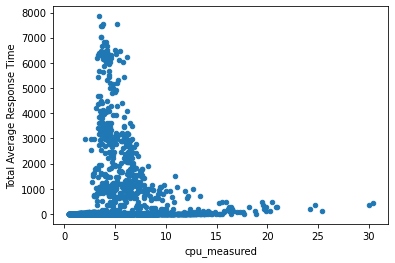

In [67]:
import matplotlib.pyplot as plt
print(col_names)
df_clean.plot(x ='cpu_measured', y='Total Average Response Time', kind = 'scatter')	
type(df_X)

### Run FLAML
In the FLAML automl run configuration, users can specify the task type, time budget, error metric, learner list, whether to subsample, resampling strategy type, and so on. All these arguments have default values which will be used if users do not provide them. For example, the default ML learners of FLAML are `['lgbm', 'xgboost', 'catboost', 'rf', 'extra_tree', 'lrl1']`. 

In [55]:
''' import AutoML class from flaml package '''
from flaml import AutoML
automl = AutoML()

In [56]:
settings = {
    "time_budget": 30,  # total running time in seconds
    "metric": 'r2',  # primary metrics can be chosen from: ['accuracy','roc_auc','f1','log_loss','mae','mse','r2']
    "task": 'regression',  # task type    
    "log_file_name": 'bops_experiment.log',  # flaml log file
}

In [57]:
'''The main flaml automl API'''
automl.fit(X_train=df_X[0:1500],y_train=df_Y[0:1500], **settings)


[flaml.automl: 06-30 05:38:34] {908} INFO - Evaluation method: cv
[flaml.automl: 06-30 05:38:34] {617} INFO - Using RepeatedKFold
[flaml.automl: 06-30 05:38:34] {929} INFO - Minimizing error metric: 1-r2
[flaml.automl: 06-30 05:38:34] {949} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree']
[flaml.automl: 06-30 05:38:34] {1013} INFO - iteration 0, current learner lgbm
[flaml.automl: 06-30 05:38:34] {1165} INFO -  at 0.1s,	best lgbm's error=0.7749,	best lgbm's error=0.7749
[flaml.automl: 06-30 05:38:34] {1013} INFO - iteration 1, current learner lgbm
[flaml.automl: 06-30 05:38:34] {1165} INFO -  at 0.1s,	best lgbm's error=0.7749,	best lgbm's error=0.7749
[flaml.automl: 06-30 05:38:34] {1013} INFO - iteration 2, current learner lgbm
[flaml.automl: 06-30 05:38:34] {1165} INFO -  at 0.2s,	best lgbm's error=0.5356,	best lgbm's error=0.5356
[flaml.automl: 06-30 05:38:34] {1013} INFO - iteration 3, current learner xgboost
[flaml.automl: 06-30 05:38:3

### Best model and metric

In [58]:
''' retrieve best config and best learner'''
print('Best ML leaner:', automl.best_estimator)
print('Best hyperparmeter config:', automl.best_config)
print('Best accuracy on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best ML leaner: extra_tree
Best hyperparmeter config: {'n_estimators': 4.0, 'max_features': 0.8608143964184548}
Best accuracy on validation data: 0.9323
Training duration of best run: 1.365 s


In [59]:
automl.model

In [60]:
''' pickle and save the automl object '''
import pickle
with open('automl.pkl', 'wb') as f:
    pickle.dump(automl, f, pickle.HIGHEST_PROTOCOL)

In [65]:
''' compute predictions of testing dataset ''' 
y_test=df_Y[1501:2000]
y_pred = automl.predict(df_X[1501:2000])
print('Predicted labels-True labels', y_pred-y_test)
#print('True labels', y_test)


Predicted labels-True labels [[4.484417777983975 4.484417777983975 4.27539807891611 ...
  -3.20857730554704 -1.1646350006062125 -1.1646350006062125]
 [4.484417777983975 4.484417777983975 4.27539807891611 ...
  -3.20857730554704 -1.1646350006062125 -1.1646350006062125]
 [4.751184265280975 4.751184265280975 4.542164566213111 ...
  -2.9418108182500395 -0.8978685133092119 -0.8978685133092119]
 ...
 [7.690244201332435 7.690244201332435 7.4812245022645705 ...
  -0.002750882198579774 2.041191422742248 2.041191422742248]
 [5.750913006332435 5.750913006332435 5.54189330726457 ...
  -1.94208207719858 0.10186022774224757 0.10186022774224757]
 [5.750913006332435 5.750913006332435 5.54189330726457 ...
  -1.94208207719858 0.10186022774224757 0.10186022774224757]]


In [64]:
''' compute different metric values on testing dataset'''
from flaml.ml import sklearn_metric_loss_score
print('accuracy', '=', 1 - sklearn_metric_loss_score('accuracy', y_pred, y_test))


ValueError: ignored

See Section 4 for an accuracy comparison with default LightGBM and XGBoost.

### Log history

In [ ]:
from flaml.data import get_output_from_log
time_history, best_valid_loss_history, valid_loss_history, config_history, train_loss_history = \
    get_output_from_log(filename=settings['log_file_name'], time_budget=60)

for config in config_history:
    print(config)

{'Current Learner': 'lgbm', 'Current Sample': 10000, 'Current Hyper-parameters': {'n_estimators': 4, 'num_leaves': 4, 'min_child_samples': 20, 'learning_rate': 0.1, 'subsample': 1.0, 'log_max_bin': 8, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 1.0, 'FLAML_sample_size': 10000}, 'Best Learner': 'lgbm', 'Best Hyper-parameters': {'n_estimators': 4, 'num_leaves': 4, 'min_child_samples': 20, 'learning_rate': 0.1, 'subsample': 1.0, 'log_max_bin': 8, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 1.0, 'FLAML_sample_size': 10000}}
{'Current Learner': 'lgbm', 'Current Sample': 40000, 'Current Hyper-parameters': {'n_estimators': 4, 'num_leaves': 4, 'min_child_samples': 20, 'learning_rate': 0.1, 'subsample': 1.0, 'log_max_bin': 8, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 1.0, 'FLAML_sample_size': 40000}, 'Best Learner': 'lgbm', 'Best Hyper-parameters': {'n_estimators': 4, 'num_leaves': 4, 'min_child_samples': 20, 'learning_rate': 0

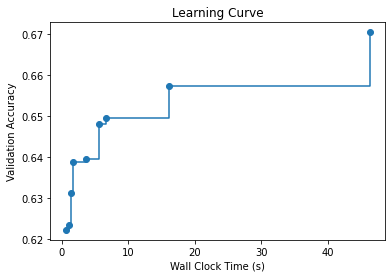

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.title('Learning Curve')
plt.xlabel('Wall Clock Time (s)')
plt.ylabel('Validation Accuracy')
plt.scatter(time_history, 1 - np.array(valid_loss_history))
plt.step(time_history, 1 - np.array(best_valid_loss_history), where='post')
plt.show()

## 3. Customized Learner

Some experienced automl users may have a preferred model to tune or may already have a reasonably by-hand-tuned model before launching the automl experiment. They need to select optimal configurations for the customized model mixed with standard built-in learners. 

FLAML can easily incorporate customized/new learners (preferably with sklearn API) provided by users in a real-time manner, as demonstrated below.

### Example of Regularized Greedy Forest

[Regularized Greedy Forest](https://arxiv.org/abs/1109.0887) (RGF) is a machine learning method currently not included in FLAML. The RGF has many tuning parameters, the most critical of which are: `[max_leaf, n_iter, n_tree_search, opt_interval, min_samples_leaf]`. To run a customized/new learner, the user needs to provide the following information:
* an implementation of the customized/new learner
* a list of hyperparameter names and types
* rough ranges of hyperparameters (i.e., upper/lower bounds)
* choose initial value corresponding to low cost for cost-related hyperparameters (e.g., initial value for max_leaf and n_iter should be small)

In this example, the above information for RGF is wrapped in a python class called *MyRegularizedGreedyForest* that exposes the hyperparameters.

In [ ]:
''' SKLearnEstimator is the super class for a sklearn learner '''
from flaml.model import SKLearnEstimator
from flaml import tune
from rgf.sklearn import RGFClassifier, RGFRegressor


class MyRegularizedGreedyForest(SKLearnEstimator):


    def __init__(self, task='binary:logistic', n_jobs=1, **params):
        '''Constructor
        
        Args:
            task: A string of the task type, one of
                'binary:logistic', 'multi:softmax', 'regression'
            n_jobs: An integer of the number of parallel threads
            params: A dictionary of the hyperparameter names and values
        '''

        super().__init__(task, **params)

        '''task=regression for RGFRegressor; 
        binary:logistic and multiclass:softmax for RGFClassifier'''
        if 'regression' in task:
            self.estimator_class = RGFRegressor
        else:
            self.estimator_class = RGFClassifier

        # convert to int for integer hyperparameters
        self.params = {
            "n_jobs": n_jobs,
            'max_leaf': int(params['max_leaf']),
            'n_iter': int(params['n_iter']),
            'n_tree_search': int(params['n_tree_search']),
            'opt_interval': int(params['opt_interval']),
            'learning_rate': params['learning_rate'],
            'min_samples_leaf': int(params['min_samples_leaf'])
        }    

    @classmethod
    def search_space(cls, data_size, task):
        '''[required method] search space

        Returns:
            A dictionary of the search space. 
            Each key is the name of a hyperparameter, and value is a dict with
                its domain and init_value (optional), cat_hp_cost (optional) 
                e.g., 
                {'domain': tune.randint(lower=1, upper=10), 'init_value': 1}
        '''
        space = {        
            'max_leaf': {'domain': tune.qloguniform(lower=4, upper=data_size, q=1), 'init_value': 4, 'low_cost_init_value': 4},
            'n_iter': {'domain': tune.qloguniform(lower=1, upper=data_size, q=1), 'init_value': 1, 'low_cost_init_value': 1},
            'n_tree_search': {'domain': tune.qloguniform(lower=1, upper=32768, q=1), 'init_value': 1, 'low_cost_init_value': 1},
            'opt_interval': {'domain': tune.qloguniform(lower=1, upper=10000, q=1), 'init_value': 100},
            'learning_rate': {'domain': tune.loguniform(lower=0.01, upper=20.0)},
            'min_samples_leaf': {'domain': tune.qloguniform(lower=1, upper=20, q=1), 'init_value': 20},
        }
        return space

    @classmethod
    def size(cls, config):
        '''[optional method] memory size of the estimator in bytes
        
        Args:
            config - the dict of the hyperparameter config

        Returns:
            A float of the memory size required by the estimator to train the
            given config
        '''
        max_leaves = int(round(config['max_leaf']))
        n_estimators = int(round(config['n_iter']))
        return (max_leaves * 3 + (max_leaves - 1) * 4 + 1.0) * n_estimators * 8

    @classmethod
    def cost_relative2lgbm(cls):
        '''[optional method] relative cost compared to lightgbm
        '''
        return 1.0


### Add Customized Learner and Run FLAML AutoML

After adding RGF into the list of learners, we run automl by tuning hyperpameters of RGF as well as the default learners. 

In [ ]:
automl = AutoML()
automl.add_learner(learner_name='RGF', learner_class=MyRegularizedGreedyForest)

In [ ]:
settings = {
    "time_budget": 60,  # total running time in seconds
    "metric": 'accuracy', 
    "estimator_list": ['RGF', 'lgbm', 'rf', 'xgboost'],  # list of ML learners
    "task": 'classification',  # task type    
    "log_file_name": 'airlines_experiment_custom.log',  # flaml log file 
    "log_training_metric": True,  # whether to log training metric
}

'''The main flaml automl API'''
automl.fit(X_train = X_train, y_train = y_train, **settings)

[flaml.automl: 05-01 16:27:27] {890} INFO - Evaluation method: holdout
[flaml.automl: 05-01 16:27:27] {596} INFO - Using StratifiedKFold
[flaml.automl: 05-01 16:27:27] {911} INFO - Minimizing error metric: 1-accuracy
[flaml.automl: 05-01 16:27:27] {929} INFO - List of ML learners in AutoML Run: ['RGF', 'lgbm', 'rf', 'xgboost']
[flaml.automl: 05-01 16:27:27] {993} INFO - iteration 0, current learner RGF
/home/dmx/miniconda2/envs/blend/lib/python3.8/site-packages/rgf/utils.py:225: UserWarning: Cannot find FastRGF executable files. FastRGF estimators will be unavailable for usage.
  warnings.warn("Cannot find FastRGF executable files. "
[flaml.automl: 05-01 16:27:30] {1141} INFO -  at 2.8s,	best RGF's error=0.3840,	best RGF's error=0.3840
[flaml.automl: 05-01 16:27:30] {993} INFO - iteration 1, current learner RGF
[flaml.automl: 05-01 16:27:31] {1141} INFO -  at 4.1s,	best RGF's error=0.3840,	best RGF's error=0.3840
[flaml.automl: 05-01 16:27:31] {993} INFO - iteration 2, current learner 

## 4. Comparison with alternatives

### FLAML's accuracy

In [ ]:
print('flaml accuracy', '=', 1 - sklearn_metric_loss_score('accuracy', y_pred, y_test))

flaml accuracy = 0.6720406982780357


### Default LightGBM

In [ ]:
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier()

In [ ]:
lgbm.fit(X_train, y_train)

LGBMClassifier()

In [ ]:
y_pred = lgbm.predict(X_test)
from flaml.ml import sklearn_metric_loss_score
print('default lgbm accuracy', '=', 1 - sklearn_metric_loss_score('accuracy', y_pred, y_test))

default lgbm accuracy = 0.6602346380315323


### Default XGBoost

In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier()

In [ ]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
y_pred = xgb.predict(X_test)
from flaml.ml import sklearn_metric_loss_score
print('default xgboost accuracy', '=', 1 - sklearn_metric_loss_score('accuracy', y_pred, y_test))

default xgboost accuracy = 0.6676060098186078
